In [1]:
import numpy as np
import pandas as pd
import torch
import segyio
import glob
import os
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar
from scipy.signal import butter
from torchaudio.functional import biquad
from tqdm import tqdm

In [2]:

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    print("MPS is available. Using MPS device.")
else:
    print("MPS not available. Using CPU.")



MPS is available. Using MPS device.


In [3]:
file = '/Users/jw1a25/research/projects/seismix/examples/output/shot_receiver_cdp_positions.csv'
df_positions = pd.read_csv(file)

In [4]:
df_positions

shot_number   shot_lat   shot_lon         shot_x        shot_y  \
0             3859 -64.987832  73.949798  450455.247118  2.792490e+06   
1             3859 -64.987832  73.949798  450455.247118  2.792490e+06   
2             3859 -64.987832  73.949798  450455.247118  2.792490e+06   
3             3859 -64.987832  73.949798  450455.247118  2.792490e+06   
4             3859 -64.987832  73.949798  450455.247118  2.792490e+06   
...            ...        ...        ...            ...           ...   
14683         3909 -65.010255  73.949852  450499.276358  2.789991e+06   
14684         3909 -65.010255  73.949852  450499.276358  2.789991e+06   
14685         3909 -65.010255  73.949852  450499.276358  2.789991e+06   
14686         3909 -65.010255  73.949852  450499.276358  2.789991e+06   
14687         3909 -65.010255  73.949852  450499.276358  2.789991e+06   

       channel_number  total_offset_m  receiver_lat  receiver_lon utm_zone  \
0                   1           206.0    -64.985985     73.949794      43D   
1                   2           218.5    -64.985873     73.949794      43D   
2                   3           231.0    -64.985761     73.949793      43D   
3                   4           243.5    -64.985648     73.949793      43D   
4                   5           256.0    -64.985536     73.949793      43D   
...               ...             ...           ...           ...      ...   
14683             284          3743.5    -64.976679     73.949772      43D   
14684             285          3756.0    -64.976567     73.949772      43D   
14685             286          3768.5    -64.976455     73.949771      43D   
14686             287          3781.0    -64.976343     73.949771      43D   
14687             288          3793.5    -64.976231     73.949771      43D   

          receiver_x    receiver_y    cdp_lat    cdp_lon          cdp_x  \
0      450451.619690  2.792696e+06 -64.986909  73.949796  450453.433401   
1      450451.399581  2.792708e+06 -64.986853  73.949796  450453.323346   
2      450451.179472  2.792721e+06 -64.986796  73.949796  450453.213291   
3      450450.959363  2.792733e+06 -64.986740  73.949796  450453.103237   
4      450450.739254  2.792746e+06 -64.986684  73.949795  450452.993182   
...              ...           ...        ...        ...            ...   
14683  450433.354284  2.793733e+06 -64.993467  73.949812  450466.314344   
14684  450433.134190  2.793745e+06 -64.993411  73.949812  450466.204290   
14685  450432.914097  2.793758e+06 -64.993355  73.949811  450466.094237   
14686  450432.694004  2.793770e+06 -64.993299  73.949811  450465.984184   
14687  450432.473912  2.793783e+06 -64.993243  73.949811  450465.874131   

              cdp_y  projected_distance  cdp  
0      2.792593e+06         3689.134857  288  
1      2.792599e+06         3682.887169  287  
2      2.792605e+06         3676.639480  286  
3      2.792612e+06         3670.391791  285  
4      2.792618e+06         3664.144102  284  
...             ...                 ...  ...  
14683  2.791862e+06         4420.112216  405  
14684  2.791868e+06         4413.864514  404  
14685  2.791875e+06         4407.616812  403  
14686  2.791881e+06         4401.369110  402  
14687  2.791887e+06         4395.121408  401  

[14688 rows x 18 columns]

In [5]:
dx = 3.125
num_channels = 288
n_shots = df_positions['shot_number'].unique().size

In [6]:
first_shot_last_rcvr = (df_positions.iloc[num_channels - 1][['receiver_x', 'receiver_y']].to_numpy())

shot_x = df_positions['shot_x'].unique()
shot_y = df_positions['shot_y'].unique()

rcvr_x = df_positions['receiver_x'].to_numpy()
rcvr_y = df_positions['receiver_y'].to_numpy()

delta_x_shot = shot_x - first_shot_last_rcvr[0]
delta_y_shot = shot_y - first_shot_last_rcvr[1]
shot_dist = np.sqrt(delta_x_shot**2 + delta_y_shot**2)
shot_grid = np.round(shot_dist / dx).astype(np.int64)

delta_x_rcvr = rcvr_x - first_shot_last_rcvr[0]
delta_y_rcvr = rcvr_y - first_shot_last_rcvr[1]
rcvr_dist = np.sqrt(delta_x_rcvr**2 + delta_y_rcvr**2)
rcvr_grid = np.round(rcvr_dist / dx).astype(np.int64)
rcvr_grid = rcvr_grid.reshape(n_shots, num_channels)


In [7]:
rcvr_grid.shape

(51, 288)

In [8]:
shot_grid.shape

(51,)

In [9]:
file = '/Users/jw1a25/research/data/hydrographic/sound_speed_profiles.csv'
df_vel = pd.read_csv(file)
twtt_sp = df_vel['twtt_seconds']
depth = df_vel['depth_metres']
intv = df_vel['interval_velocity_time_mean']
rms = df_vel['rms_velocity_time_mean']

depth_resamp = np.arange(0, 3000, dx)
# twtt_resamp = np.arange(0, 4, 0.008)
interp_func_rms = interp1d(depth, rms, kind='linear', bounds_error=False, fill_value='extrapolate')
interp_func_intv = interp1d(depth, intv, kind='linear', bounds_error=False, fill_value='extrapolate')
rms_resamp = interp_func_rms(depth_resamp)
intv_resamp = interp_func_intv(depth_resamp)

# v_rms = np.broadcast_to(rms_resamp[:, np.newaxis], (twtt_resamp.shape[0], shot_grid.max()+1))
v_intv= np.broadcast_to(intv_resamp[np.newaxis, :], (shot_grid.max()+1, depth_resamp.shape[0]))
v_init = gaussian_filter(v_intv, sigma=[10, 10]).astype(np.float32)

print(v_init.max(), v_init.min())
max_vel = 1500
min_vel = 1400

1469.0 1444.222


In [10]:
v_init.shape

(2014, 960)

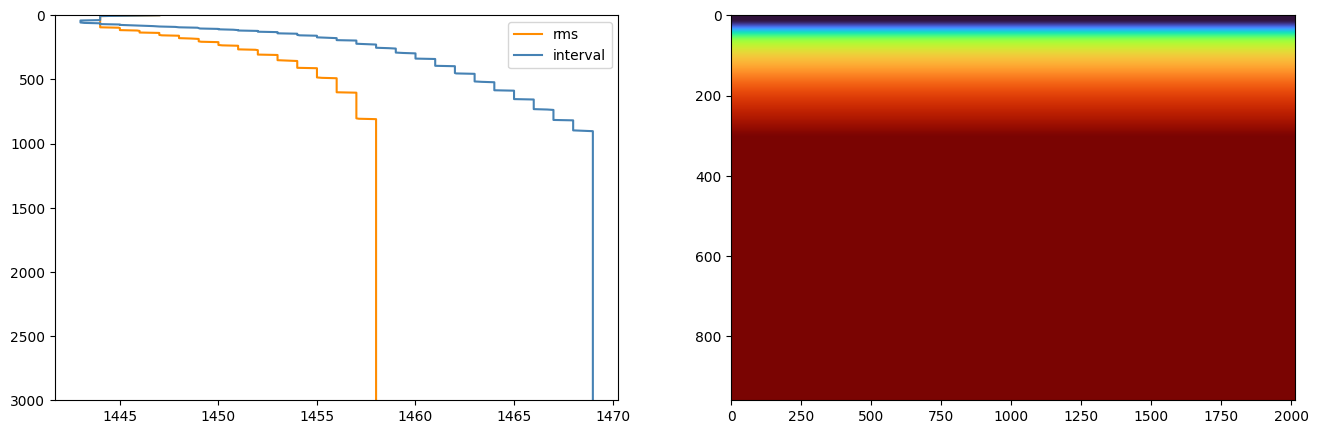

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(rms_resamp, depth_resamp, c='darkorange', label='rms')
axes[0].plot(intv_resamp, depth_resamp, c='steelblue', label='interval')
axes[0].set_ylim(3000, 0)
axes[0].legend()

axes[1].imshow(v_init.T, aspect='auto', cmap="turbo")

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nx, ny = v_init.shape
print(nx, ny)
v_init = torch.tensor(v_init).float().to(device)
v = v_init.clone()


2014 960


In [13]:
n_shots = df_positions['shot_number'].unique().size

n_sources_per_shot = 1
source_depth = 1  # 2 * 4m = 8m

n_receivers_per_shot = num_channels
receiver_depth = 1  # 2 * 4m = 8m

freq = 30
dt = 0.004
nt = 800
peak_time = 1.5 / freq


In [14]:
segyfile = segyio.open(
    '/Users/jw1a25/research/projects/seismix/examples/output/228_0903_short_out.sgy',
    ignore_geometry=True,
    mode="r+",
)
segyfile.mmap()
headers = segyio.tracefield.keys
ntraces = segyfile.tracecount
df = pd.DataFrame(index=range(1, ntraces + 1), columns=headers.keys())
for ii, jj in headers.items():
    df[ii] = segyfile.attributes(jj)[:]
offsets = df['offset'][0:288].to_numpy()
ns = segyfile.samples.size
dt_s = segyio.tools.dt(segyfile) / 10**6
data = segyfile.trace.raw[:].reshape(n_shots, num_channels, ns)

dw_path = '/Users/jw1a25/research/projects/seismix/examples/tmp/'
search = os.path.join(dw_path, '*.npy')
dw_files = glob.glob(search)
dw_files.sort()

vp_water = 1460
dw_time = offsets / vp_water
dw_ring_time = dw_time + 0.1
dw_samples = (dw_time / dt_s).astype(int)
dw_ring_samples = (dw_ring_time / dt_s).astype(int)
col_indices = np.arange(ns)[np.newaxis, :]
dw_mask = col_indices < dw_samples[:, np.newaxis]
dw_ring_mask = col_indices > dw_ring_samples[:, np.newaxis]

# Ensure the number of files matches the expected dimension
if len(dw_files) != n_shots:
    print(f"Warning: Found {len(npy_files)} files, expected {expected_files}.")

for ii, path in enumerate(dw_files):
    try:
        dw = np.load(path)
        if dw.shape != (num_channels, ns):
            raise ValueError(f"Incorrect shape of the direct wave {dw.shape}")
        dw[dw_ring_mask] = 0
        data[ii] = data[ii] + dw
        data[ii][dw_mask] = 0
        
    except Exception as e:
        print(f"Error loading {path}: {e}")
    
print("Successfully add in direct wave.")


observed_data = torch.tensor(data)
observed_data = (
    observed_data[:, :, :nt].to(device)
)


Successfully add in direct wave.


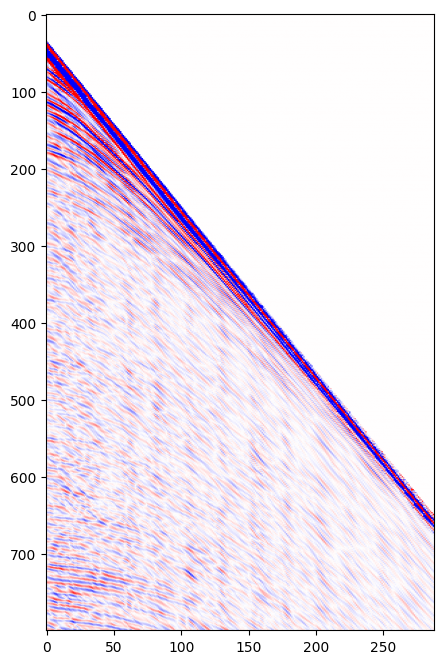

In [15]:
clip_percentile = 99.
vm = np.percentile(observed_data[10], clip_percentile)
f'The {clip_percentile}th percentile is {vm:.0000f}; the max amplitude is {data.max():.0000f}'

fig, ax = plt.subplots(1, 1, figsize=(5, 8))
ax.imshow(observed_data[10].T, vmin = -vm, vmax=vm, aspect='auto', cmap='bwr')

In [16]:
# source_locations
source_locations = torch.zeros(n_shots, n_sources_per_shot, 2,
                               dtype=torch.long, device=device)
source_locations[:, 0, 0] = torch.tensor(shot_grid)
source_locations[..., 1] = source_depth

# receiver_locations
receiver_locations = torch.zeros(n_shots, n_receivers_per_shot, 2,
                                 dtype=torch.long, device=device)
receiver_locations[:, :, 0] = torch.tensor(rcvr_grid)
receiver_locations[..., 1] = receiver_depth

# source_amplitudes
source_amplitudes = (
    (deepwave.wavelets.ricker(freq, nt, dt, peak_time))
    .repeat(n_shots, n_sources_per_shot, 1).to(device)
)


In [17]:
receiver_locations.shape

torch.Size([51, 288, 2])

In [18]:
source_locations.shape

torch.Size([51, 1, 2])

In [19]:
# forward modeling test
out = scalar(v, dx, dt, source_amplitudes=source_amplitudes,
             source_locations=source_locations,
             receiver_locations=receiver_locations,
             accuracy=8,
             pml_freq=freq,
             pml_width=[20, 20, 0, 20],
             max_vel=max_vel
            )

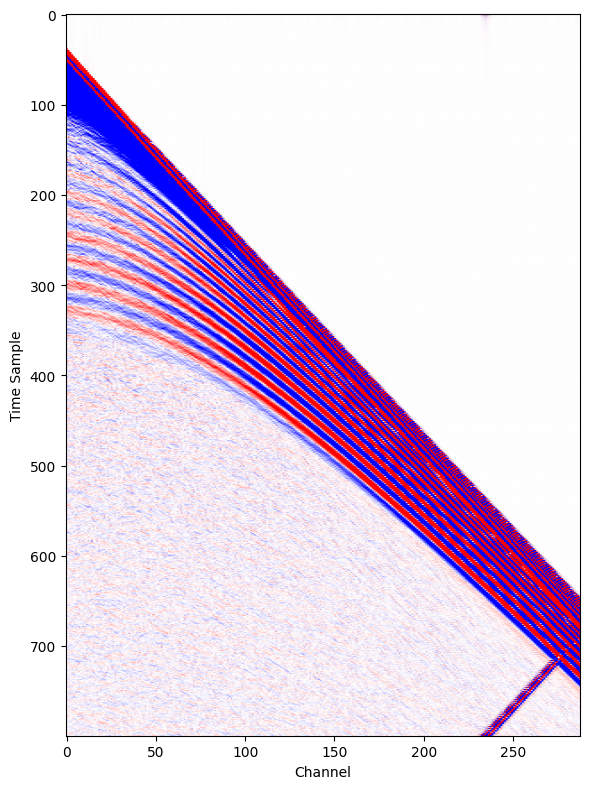

In [20]:
receiver_amplitudes = out[-1].cpu().numpy()
vm = np.percentile(receiver_amplitudes[0], 95)
_, ax = plt.subplots(1, 1, figsize=(6, 8), sharey=True)
ax.imshow(receiver_amplitudes[0].T, aspect='auto',
             cmap='bwr', vmin=-vm, vmax=vm)
ax.set_xlabel("Channel")
ax.set_ylabel("Time Sample")

plt.tight_layout()

In [20]:
def Xcorr(x,y):
    x = x/torch.norm(x)
    y = y/torch.norm(y)
    loss = -torch.sum(torch.mul(x,y))
    return loss

Epoch 0: 100%|██████████████████████████████| 7/7 [25:03<00:00, 214.81s/it, loss=-0]


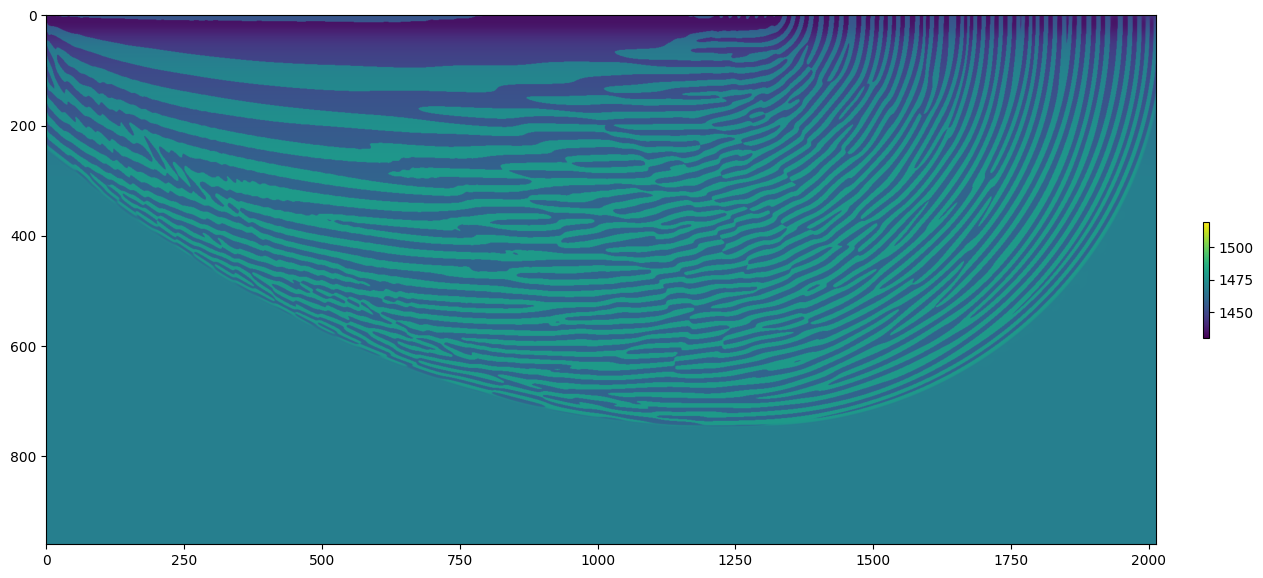

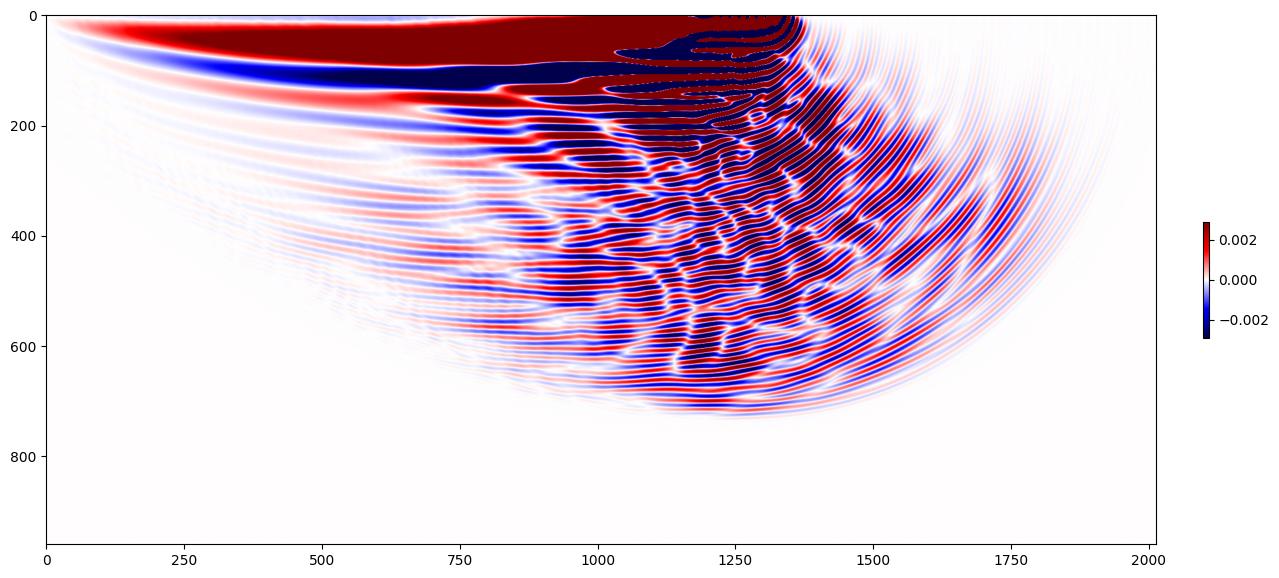

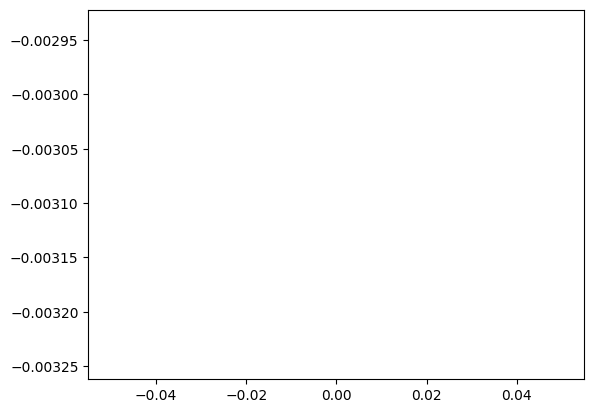

Epoch 5: 100%|███████████████████████████| 7/7 [7:55:57<00:00, 4079.70s/it, loss=-0]


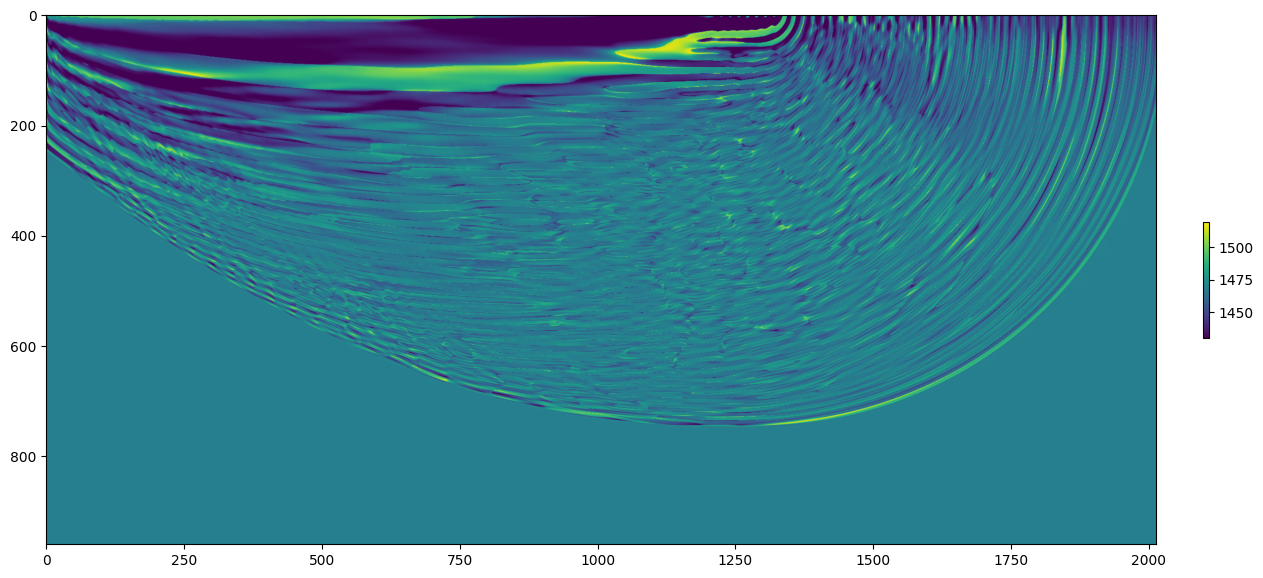

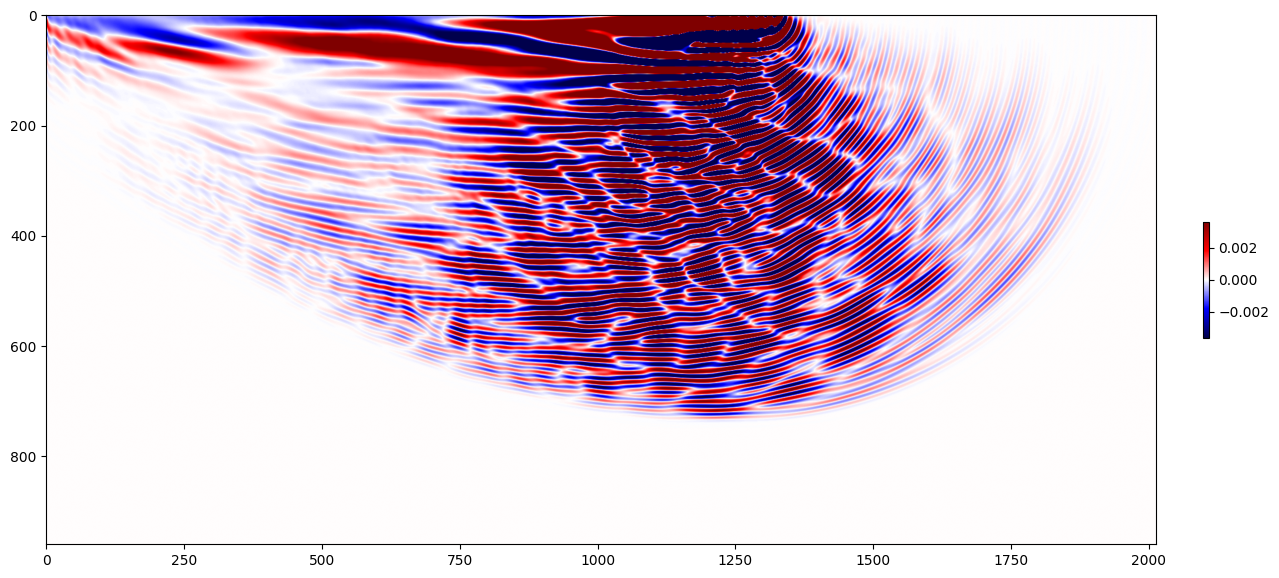

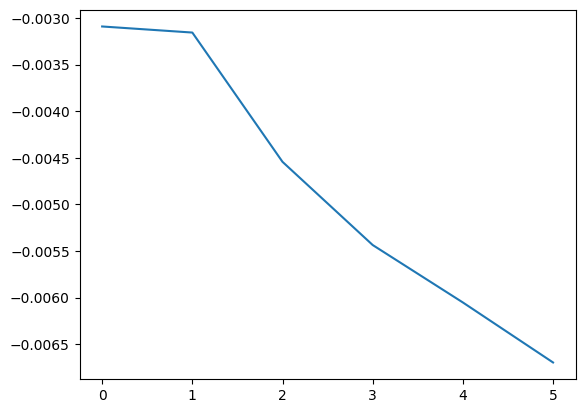

Epoch 10: 100%|█████████████████████████████| 7/7 [24:57<00:00, 213.86s/it, loss=-0]


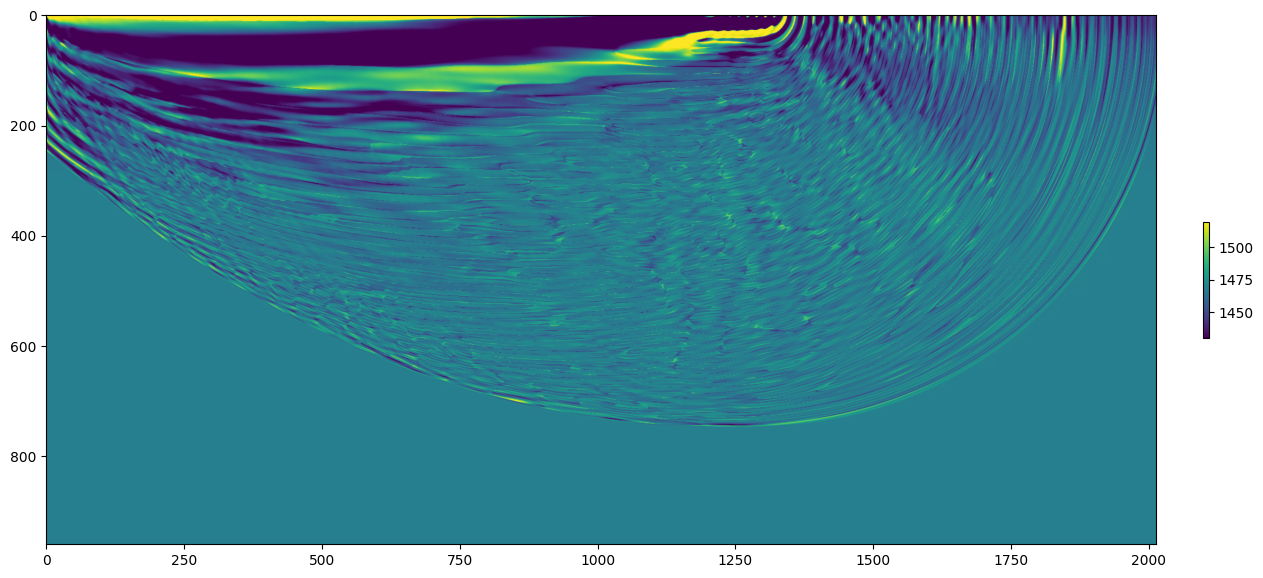

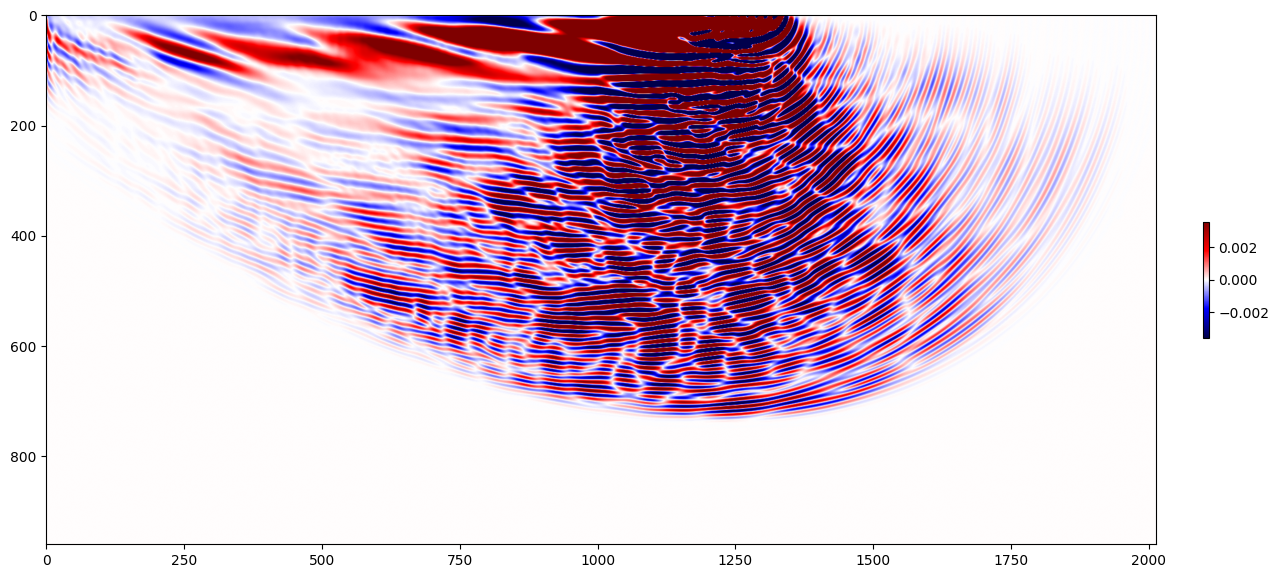

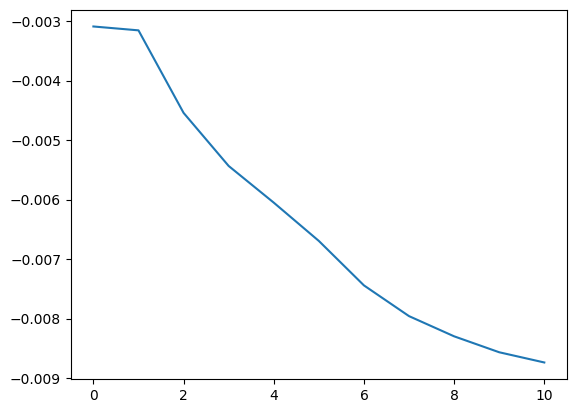

Epoch 15: 100%|█████████████████████████████| 7/7 [23:45<00:00, 203.68s/it, loss=-0]


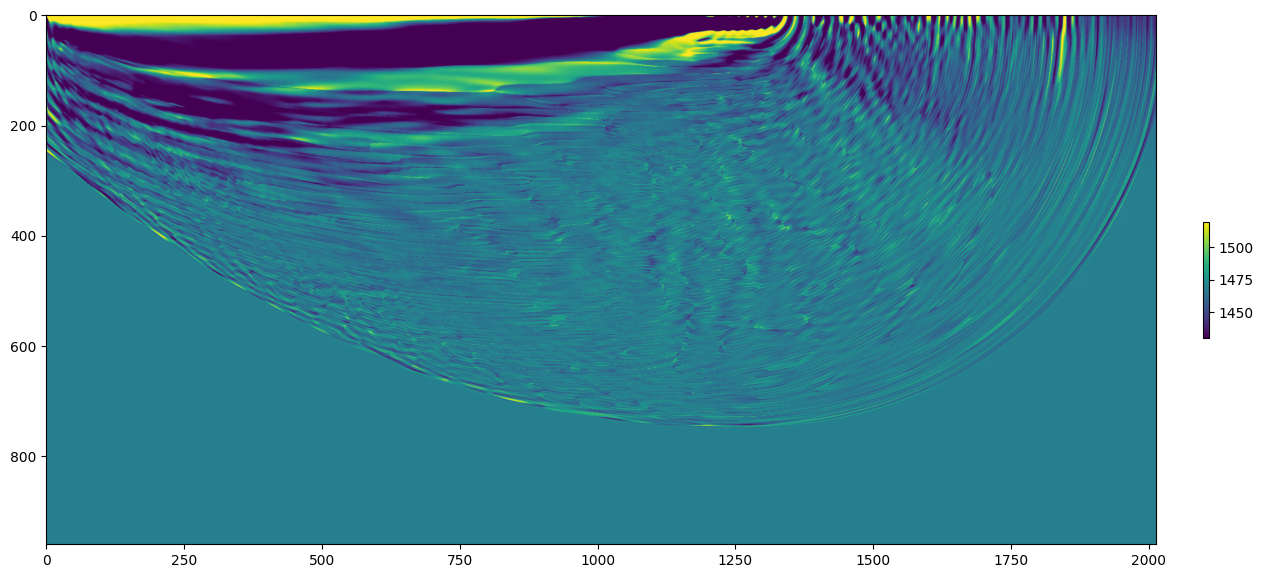

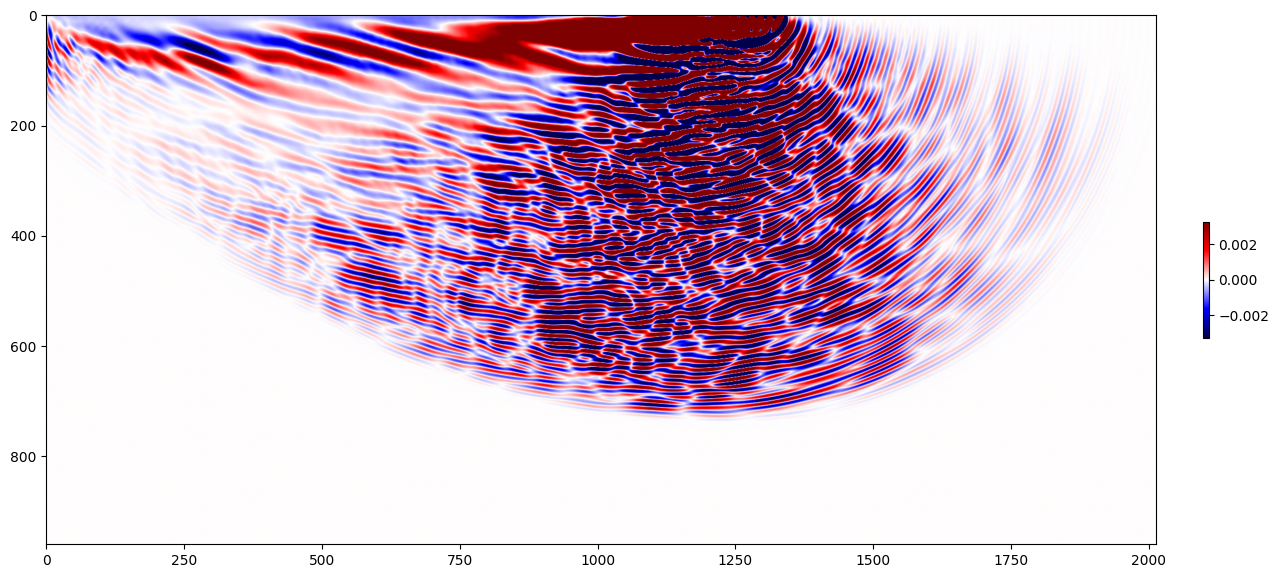

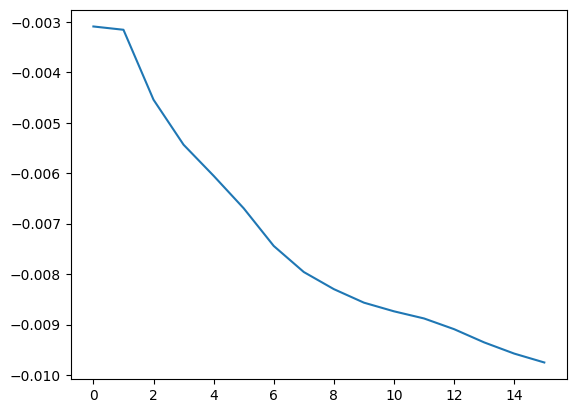

Epoch 20: 100%|█████████████████████████████| 7/7 [23:35<00:00, 202.26s/it, loss=-0]


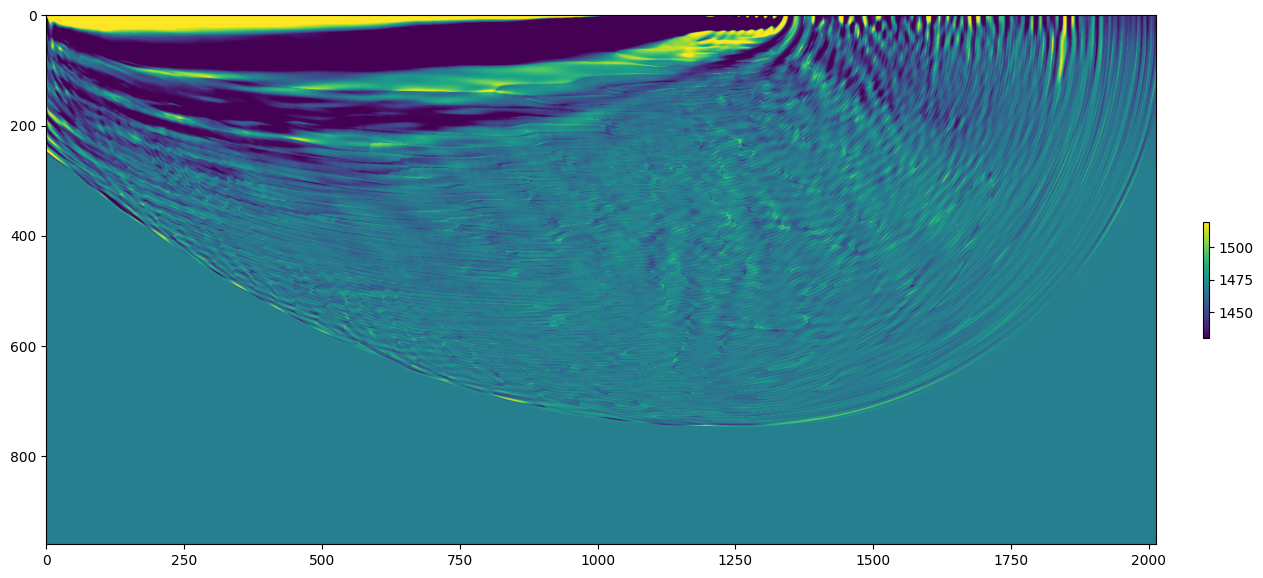

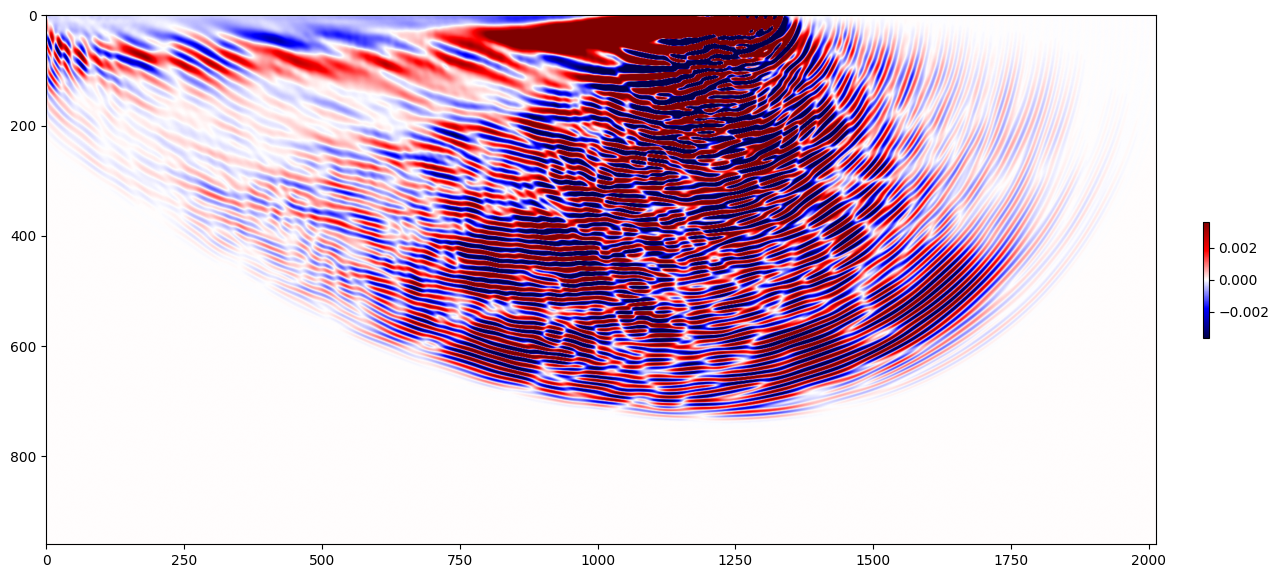

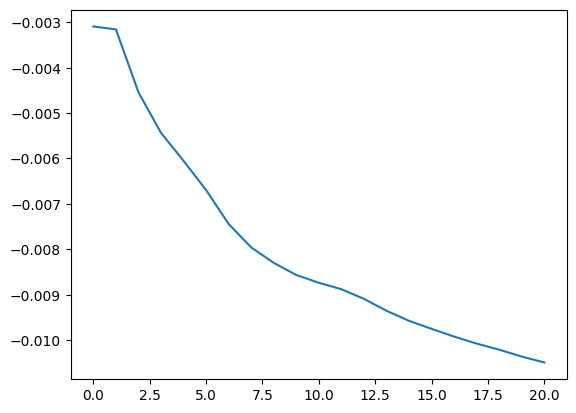

Epoch 25:  14%|███▍                    | 1/7 [04:42<28:12, 282.10s/it, loss=-0.551]

In [ ]:
# inversion
v.requires_grad_()

# Run optimisation/inversion
n_epochs = 200
batch_size = 8
w_smooth = 2
box_min = 1430. 
box_max = 1520.
  
for cutoff_freq in [15]:
    sos = butter(6, cutoff_freq, fs=1/dt, output='sos')
    sos = [torch.tensor(sosi).to(observed_data.dtype).to(device)
           for sosi in sos]

    def filt(x):
        return biquad(biquad(biquad(x, *sos[0]), *sos[1]), *sos[2])
    
    observed_data_filt = filt(observed_data)
    source_amplitudes_filt = filt(source_amplitudes)

scaler = torch.max(torch.abs(observed_data_filt))
observed_data_filt /= scaler

optimiser = torch.optim.Adam([v], lr=10)

loss_fn = torch.nn.MSELoss()
epoch_loss = []

# print(f"Inverting for frequency: {cutoff_freq}")

for epoch in range(n_epochs):
    running_loss = 0
    optimiser.zero_grad()
    loop_batch = tqdm(range(0, n_shots, batch_size), leave=True)
    for i in loop_batch:
        out = scalar(
            v, dx, dt,
            source_amplitudes=source_amplitudes_filt[i:i+batch_size, :, :],
            source_locations=source_locations[i:i+batch_size, :, :],
            receiver_locations=receiver_locations[i:i+batch_size, :, :],
            accuracy=8,
            pml_freq=freq, 
            pml_width=[20, 20, 0, 20],
            max_vel=box_max
        )
        # Normalize output
        predicted = out[-1]
        predicted = predicted / scaler
        
        selected_observed_data = observed_data_filt[i:i+batch_size, :, :]
        loss = Xcorr(predicted[i:i+batch_size, :], 
                     selected_observed_data[i:i+batch_size, :].to(device))
        running_loss += loss.item()
        loss.backward()
        
        loop_batch.set_description(f'Epoch {epoch}')
        loop_batch.set_postfix(loss=loss.item())
        
    epoch_loss.append(running_loss / n_shots)
    
    if epoch==0: gmax = torch.abs(v.grad).max()
    v.grad = v.grad / gmax  #* v_mask.to(device)
    
    # Smooth gradient
    v.grad = torch.tensor(gaussian_filter(v.grad.cpu().numpy(), w_smooth)).to(device)
    
    grad_plot = v.grad.detach().clone().cpu()

    optimiser.step()
    
    with torch.no_grad():
        v[v > box_max] = box_max
        v[v < box_min] = box_min

    if epoch == 0 or epoch % 5 == 0 or epoch == n_epochs - 1:
        plt.figure(figsize=(15, 7.5))
        im = plt.imshow(v.detach().cpu().T, vmin=box_min, vmax=box_max)
        plt.colorbar(im, fraction=0.005, pad=0.04)
        plt.show()
        
        plt.figure(figsize=(15, 7.5))
        vmin, vmax = torch.quantile(grad_plot.T, torch.tensor([0.05, 0.95]))
        im = plt.imshow(grad_plot.T, cmap='seismic', vmin=-vmax, vmax=vmax)
        plt.colorbar(im, fraction=0.005, pad=0.04)
        plt.show()
        
        plt.figure()
        plt.plot(epoch_loss)
        plt.show()